# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Training stats](#Training-stats)
* [Save model and resources](#Save-model-and-resources)
* [Test model](#Test-model)

In [1]:
# # codecarbon - start tracking
# from codecarbon import EmissionsTracker

# tracker = EmissionsTracker(log_level = "WARNING", save_to_api = True, experiment_id = "6d2c8401-afba-42de-9600-6e95bea5fd80")
# tracker.start()

# Imports

In [2]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [3]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib.dataset import *
from lib.directories import init_cache_dir, init_model_dir
from lib.io import export_model
from lib.model import top_labeled_predictions, top_predictions_table
from lib.plot import plot_training_stat

2022-06-08 18:30:57.457218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 18:30:57.457286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [4]:
MODEL_BASE_DIR = pathlib.Path('../model')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value, only affects execution time

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train[:5%]'
VAL_SPLIT = 'train[5%:6%]'
TEST_SPLIT = 'train[6%:7%]'

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `load_dataset('off_categories', ...)` to access the dataset.

In [5]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [6]:
tf.random.set_seed(42)

## Model inputs

In [7]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [8]:
ds = load_dataset('off_categories', split=TRAIN_SPLIT)

2022-06-08 18:30:58.584101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 18:30:58.584128: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 18:30:58.584139: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alba): /proc/driver/nvidia/version does not exist
2022-06-08 18:30:58.584326: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = 93_000,
    output_sequence_length = 30)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = 64,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = 64,
    recurrent_dropout = 0.2,
    dropout = 0.0))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

CPU times: user 2 s, sys: 913 ms, total: 2.91 s
Wall time: 753 ms


21947

In [10]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 3,
    max_tokens = 5_000)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

CPU times: user 2.46 s, sys: 1.26 s, total: 3.71 s
Wall time: 711 ms


5000

## Model output

In [11]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 10)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)

def categories_encode(ds: tf.data.Dataset):
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )

len(categories_vocab)

CPU times: user 2.31 s, sys: 1.23 s, total: 3.54 s
Wall time: 649 ms


1238

## Model

In [12]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs[k] for k in features], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
 ization)                                                                                         
                                                                                                  
 ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       1404608     ['text_vectorization[0][0]'] 

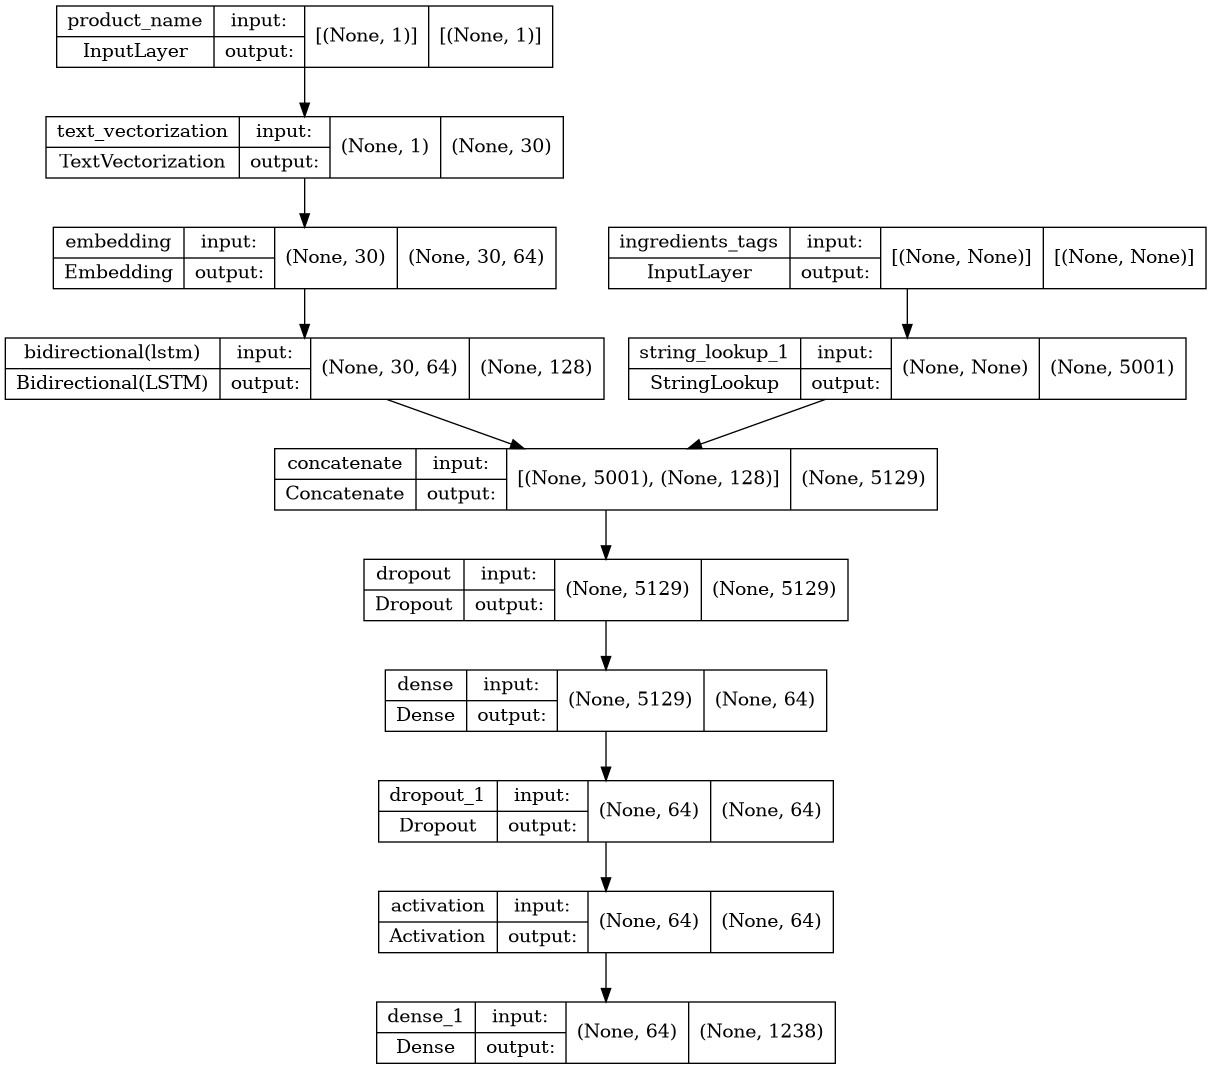

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [15]:
%%time

# Remember to clean obsolete dirs once in a while
MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
CACHE_DIR = init_cache_dir(CACHE_DIR)

batch_size = 128

ds_train = (
    load_dataset('off_categories', split=TRAIN_SPLIT, features=features, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset('off_categories', split=VAL_SPLIT, features=features, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = 3,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

Model directory: ../model.20220608-183100
Cache directory: ../tensorflow_cache
Epoch 1/3


2022-06-08 18:31:01.281343: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


    325/Unknown - 17s 43ms/step - loss: 0.0607 - binary_accuracy: 0.9884 - precision: 0.0043 - recall: 0.0091

2022-06-08 18:31:18.200896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-08 18:31:19.432428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-08 18:31:20.996229: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so con

INFO:tensorflow:Assets written to: ../model.20220608-183100/weights.01-0.0179/assets


INFO:tensorflow:Assets written to: ../model.20220608-183100/weights.01-0.0179/assets


325/325 [==============================] - 23s 61ms/step - loss: 0.0607 - binary_accuracy: 0.9884 - precision: 0.0043 - recall: 0.0091 - val_loss: 0.0179 - val_binary_accuracy: 0.9963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3


2022-06-08 18:31:23.934788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


324/325 [============================>.] - ETA: 0s - loss: 0.0182 - binary_accuracy: 0.9963 - precision: 0.5455 - recall: 1.2521e-04INFO:tensorflow:Assets written to: ../model.20220608-183100/weights.02-0.0175/assets


INFO:tensorflow:Assets written to: ../model.20220608-183100/weights.02-0.0175/assets


325/325 [==============================] - 18s 55ms/step - loss: 0.0182 - binary_accuracy: 0.9963 - precision: 0.5455 - recall: 1.2512e-04 - val_loss: 0.0175 - val_binary_accuracy: 0.9963 - val_precision: 0.6957 - val_recall: 4.1536e-04
Epoch 3/3
324/325 [============================>.] - ETA: 0s - loss: 0.0176 - binary_accuracy: 0.9963 - precision: 0.6451 - recall: 0.0088INFO:tensorflow:Assets written to: ../model.20220608-183100/weights.03-0.0168/assets


INFO:tensorflow:Assets written to: ../model.20220608-183100/weights.03-0.0168/assets


325/325 [==============================] - 22s 67ms/step - loss: 0.0176 - binary_accuracy: 0.9963 - precision: 0.6454 - recall: 0.0088 - val_loss: 0.0168 - val_binary_accuracy: 0.9963 - val_precision: 0.7251 - val_recall: 0.0176
CPU times: user 4min 7s, sys: 23.6 s, total: 4min 30s
Wall time: 1min 2s


## Training stats

In [16]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.988432,0.060728,0.004288,0.009077,0.996263,0.017941,0.000000,0.000000
1,1,0.996267,0.018200,0.545455,0.000125,0.996264,0.017476,0.695652,0.000415
2,2,0.996282,0.017586,0.645358,0.008842,0.996304,0.016839,0.725134,0.017601


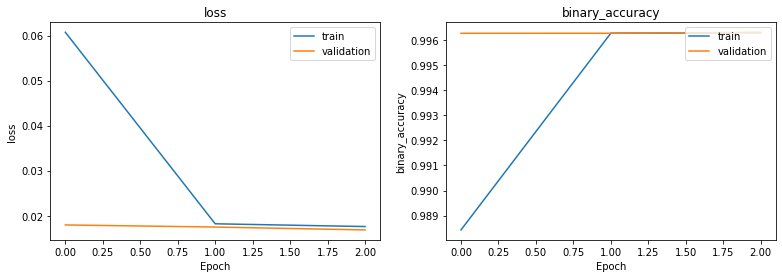

In [17]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

plot_training_stat(stats, 'loss', ax1)
plot_training_stat(stats, 'binary_accuracy', ax2)

# Save model and resources

In [18]:
@tf.function
def serving_func(*args, **kwargs):
    preds = model(*args, **kwargs)
    return top_labeled_predictions(preds, categories_vocab, k=50)

export_model(model, MODEL_DIR/'saved_model', serving_func)

INFO:tensorflow:Assets written to: ../model.20220608-183100/saved_model/assets


INFO:tensorflow:Assets written to: ../model.20220608-183100/saved_model/assets


# Test model

In [19]:
m = tf.keras.models.load_model(MODEL_DIR/'saved_model')

In [20]:
ds_test = load_dataset('off_categories', split=TEST_SPLIT)

In [21]:
%%time

preds_test = m.predict(ds_test.padded_batch(128))
preds_test

/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


CPU times: user 3.52 s, sys: 331 ms, total: 3.85 s
Wall time: 953 ms


array([[3.5351348e-01, 2.8579676e-01, 1.3108164e-01, ..., 3.0219555e-04,
        3.8042665e-04, 3.1426549e-04],
       [3.4899420e-01, 2.8012705e-01, 1.2621081e-01, ..., 2.4080276e-04,
        3.0526519e-04, 2.5054812e-04],
       [1.2648547e-01, 1.1779645e-01, 6.4248723e-01, ..., 5.5976754e-05,
        7.7357909e-05, 7.5006254e-05],
       ...,
       [2.9263401e-01, 2.2844997e-01, 1.5597159e-01, ..., 1.2734532e-04,
        1.5076995e-04, 1.2045219e-04],
       [3.5273394e-01, 2.8485849e-01, 1.3031837e-01, ..., 2.9155612e-04,
        3.6758184e-04, 3.0329823e-04],
       [3.5371846e-01, 2.8606802e-01, 1.3144541e-01, ..., 3.0612946e-04,
        3.8516521e-04, 3.1828880e-04]], dtype=float32)

In [22]:
# This is the function exported as the default serving function in our saved model
top_preds_test = top_labeled_predictions(preds_test, categories_vocab, k=3)

# Same data, but pretty
pred_table_test = top_predictions_table(top_preds_test)

# Add some interpretable features to the final table
extra_cols_test = as_dataframe(select_features(ds_test, ['code', 'product_name']))

pd.concat([extra_cols_test, pred_table_test], axis=1)

,code,product_name,top prediction 1,top prediction 2,top prediction 3
0,4018905525166,Apfelmus,en:plant-based-foods-and-beverages: 35.35%,en:plant-based-foods: 28.58%,en:beverages: 15.36%
1,8715700111421,BBQ SAUCE ORIGIL,en:plant-based-foods-and-beverages: 34.9%,en:plant-based-foods: 28.01%,en:beverages: 14.72%
2,0076410400013,Choc-o lunch cookies,en:snacks: 64.25%,en:sweet-snacks: 50.02%,en:biscuits-and-cakes: 41.55%
3,0030243670159,Onion petals,en:plant-based-foods-and-beverages: 19.81%,en:plant-based-foods: 17.7%,en:snacks: 16.16%
4,6935630302436,Flowery Age,en:plant-based-foods-and-beverages: 35.25%,en:plant-based-foods: 28.45%,en:beverages: 15.22%
...,...,...,...,...,...
8571,3547130084359,Huile olive & piment,en:plant-based-foods-and-beverages: 36.36%,en:plant-based-foods: 29.85%,en:beverages: 16.81%
8572,0030223040873,Power Greens Fresh Collard Greens,en:plant-based-foods-and-beverages: 35.23%,en:plant-based-foods: 28.26%,en:beverages: 14.84%
8573,0041512155543,"Pink lemonade drink mix, pink lemonade",en:plant-based-foods-and-beverages: 29.26%,en:plant-based-foods: 22.84%,en:snacks: 15.6%
8574,8000879350154,Mandorle sgusciate,en:plant-based-foods-and-beverages: 35.27%,en:plant-based-foods: 28.49%,en:beverages: 15.25%


In [23]:
# # codecarbon - stop tracking
# tracker.stop()